Needs scikilt-learn 0.22

```
pip uninstall scikit-learn
pip install scikit-learn==0.22
```

In [1]:
import ast
import os
import pickle
import re
from collections import OrderedDict
from configparser import ConfigParser
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.mixture import GaussianMixture
from scipy.special import iv, logsumexp
from sklearn.neighbors import NearestNeighbors
from tqdm.notebook import tqdm

import sys
sys.path.append('../')
sys.path.append('../src')
from src.snapconfig import config
config.PARAM_PATH = '../config.ini'
import run_train as main
from src.snaptrain import dataset, trainmodel
from src.snaputils import simulatespectra as sim

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np

In [3]:
def normalize_values(values):
    min_val, max_val = min(values), max(values)
    vals = np.array(values)
    normalized_values = (vals - min_val) / (max_val - min_val)
    return normalized_values

def scatter_plot(x, y, x_label, y_label, title, legend=None, save_path=None):
    plt.figure(figsize=(6, 4))
    plt.scatter(normalize_values(x), normalize_values(y), alpha=0.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    if legend is not None:
        plt.legend()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

def plot_roc_curve(fpr, tpr, roc_auc_snap_label, optimal_idx, label=None):
    # Plot the ROC curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_snap_label:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([0, fpr[optimal_idx]], [tpr[optimal_idx], tpr[optimal_idx]], 'k--', color='blue')
    plt.plot([fpr[optimal_idx], fpr[optimal_idx]], [0, tpr[optimal_idx]], 'k--', color='blue')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()

Training RandomForestRegressor...
ROC AUC snap_label: 0.9996107148799839
Optimal threshold: 0.55
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1773
           1       0.99      0.99      0.99      1827

    accuracy                           0.99      3600
   macro avg       0.99      0.99      0.99      3600
weighted avg       0.99      0.99      0.99      3600



/tmp/ipykernel_1504209/516002398.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, fpr[optimal_idx]], [tpr[optimal_idx], tpr[optimal_idx]], 'k--', color='blue')
/tmp/ipykernel_1504209/516002398.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[optimal_idx], fpr[optimal_idx]], [0, tpr[optimal_idx]], 'k--', color='blue')


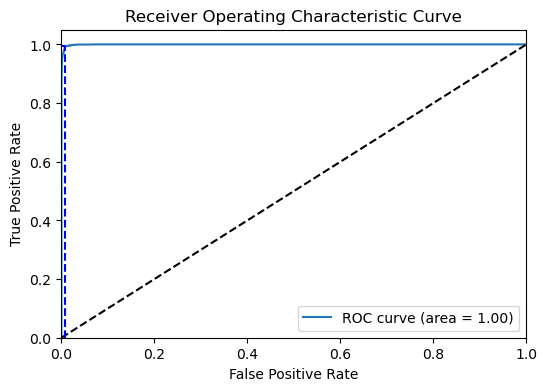

Feature Importances for RandomForestRegressor:
         Feature  Importance
2    consistency    0.876726
3          sim_Y    0.090053
1        density    0.021146
0     variations    0.009929
4  spec_charge_2    0.001040
5  spec_charge_3    0.000914
6  spec_charge_4    0.000192
7  spec_charge_5    0.000000


Training GradientBoostingRegressor...
ROC AUC snap_label: 0.9993458404684264
Optimal threshold: 0.5394936687111013
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1773
           1       0.99      0.99      0.99      1827

    accuracy                           0.99      3600
   macro avg       0.99      0.99      0.99      3600
weighted avg       0.99      0.99      0.99      3600



/tmp/ipykernel_1504209/516002398.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, fpr[optimal_idx]], [tpr[optimal_idx], tpr[optimal_idx]], 'k--', color='blue')
/tmp/ipykernel_1504209/516002398.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[optimal_idx], fpr[optimal_idx]], [0, tpr[optimal_idx]], 'k--', color='blue')


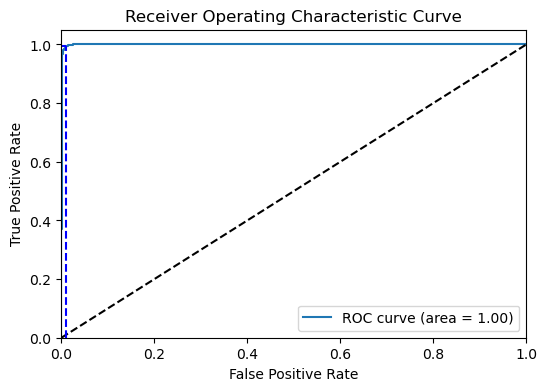

Feature Importances for GradientBoostingRegressor:
         Feature    Importance
2    consistency  8.747741e-01
3          sim_Y  9.548242e-02
1        density  1.803139e-02
0     variations  1.038160e-02
5  spec_charge_3  6.663740e-04
4  spec_charge_2  6.108551e-04
6  spec_charge_4  5.314489e-05
7  spec_charge_5  7.605852e-08


Training GradientBoostingClassifier...
ROC AUC snap_label: 0.9924608036808281
Optimal threshold: 1.0
Best hyperparameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1773
           1       0.99      1.00      0.99      1827

    accuracy                           0.99      3600
   macro avg       0.99      0.99      0.99      3600
weighted avg       0.99      0.99      0.99      3600



/tmp/ipykernel_1504209/516002398.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, fpr[optimal_idx]], [tpr[optimal_idx], tpr[optimal_idx]], 'k--', color='blue')
/tmp/ipykernel_1504209/516002398.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[optimal_idx], fpr[optimal_idx]], [0, tpr[optimal_idx]], 'k--', color='blue')


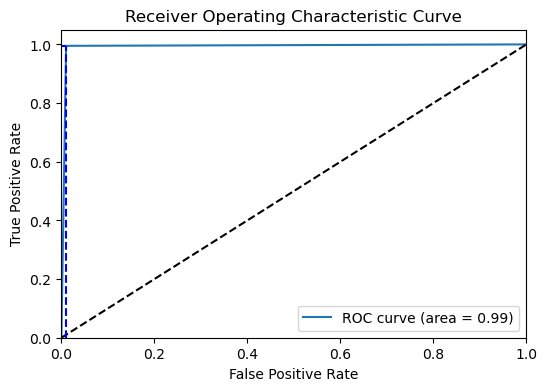

Feature Importances for GradientBoostingClassifier:
         Feature  Importance
2    consistency    0.903778
3          sim_Y    0.078771
1        density    0.012955
0     variations    0.004051
4  spec_charge_2    0.000389
5  spec_charge_3    0.000051
6  spec_charge_4    0.000005
7  spec_charge_5    0.000000




In [17]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_curve

# Load the data
df_all = pd.read_csv('outputs/data_df.csv')

# Preprocess the data
df_all.drop('id', axis=1, inplace=True)
df_all = pd.get_dummies(df_all, columns=['spec_charge'])

# Define the feature columns
feature_cols = [col for col in df_all.columns if col not in ['label', 'spec_mass', 'sim_X']]
# feature_cols = ['density', 'consistency']

# Define the label columns
label_cols = ['label']

# Separate the features and labels
X = df_all[feature_cols]
y = df_all[label_cols]

# Standardize the features
scaler = StandardScaler()
scaler.fit_transform(X)

# Apply SMOTE for 'label'
smote = SMOTE(random_state=42)
# X_res, y_res = smote.fit_resample(X, y['label'])
X_res, y_res = X, y['label']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Define the models and their associated hyperparameters
models = [
    {
        'name': 'RandomForestRegressor',
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [1, 10, 20, 30, 40],
            'min_samples_split': [2, 5, 10]
        }
    },
    {
        'name': 'GradientBoostingRegressor',
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'max_depth': [3, 5, 10, 20]
        }
    },
    {
        'name': 'GradientBoostingClassifier',
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'max_depth': [3, 5, 10, 20]
        }
    }
]

# Loop over the models
for m in models:
    print(f"Training {m['name']}...")

    # Apply GridSearchCV
    grid = GridSearchCV(m['model'], m['params'], cv=5, verbose=0, n_jobs=-1)
    grid.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_proba = grid.predict(X_val)

    # Scatter plot of y_pred_proba vs snap_score_1
    # scatter_plot(y_val['snap_1'], y_pred_proba, 'snap_score_1', 'y_pred_proba', f"Plot for {m['name']}", legend=True)

    # Calculate the ROC AUC for snap_label
    roc_auc_snap_label = roc_auc_score(y_val, y_pred_proba)

    # Print the ROC AUC
    print(f"ROC AUC snap_label: {roc_auc_snap_label}")

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

    # Find the optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # Print the optimal threshold
    print(f"Optimal threshold: {optimal_threshold}")

    # Convert probabilities to binary predictions using the optimal threshold
    y_pred_snap_label = (y_pred_proba >= optimal_threshold).astype(int)

    # Print the best hyperparameters
    print(f"Best hyperparameters: {grid.best_params_}")

    # Print the classification report for snap_label
    print(classification_report(y_val, y_pred_snap_label))

    # Plot the ROC curve
    plot_roc_curve(fpr, tpr, roc_auc_snap_label, optimal_idx)

    # Get the feature importances
    feature_importances = grid.best_estimator_.feature_importances_

    # Create a DataFrame to display the feature importances
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': feature_importances
    })

    # Sort the DataFrame by importance in descending order
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Print the feature importances
    print(f"Feature Importances for {m['name']}:")
    print(importance_df)
    print("\n")


Training RandomForestRegressor...


ROC AUC snap_label: 0.8588410927554888
Optimal threshold: 0.3112988033707723
Best hyperparameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1770
           1       0.72      0.71      0.72       948

    accuracy                           0.81      2718
   macro avg       0.79      0.78      0.78      2718
weighted avg       0.80      0.81      0.80      2718



/tmp/ipykernel_1433252/547698018.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, fpr[optimal_idx]], [tpr[optimal_idx], tpr[optimal_idx]], 'k--', color='blue')
/tmp/ipykernel_1433252/547698018.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[optimal_idx], fpr[optimal_idx]], [0, tpr[optimal_idx]], 'k--', color='blue')


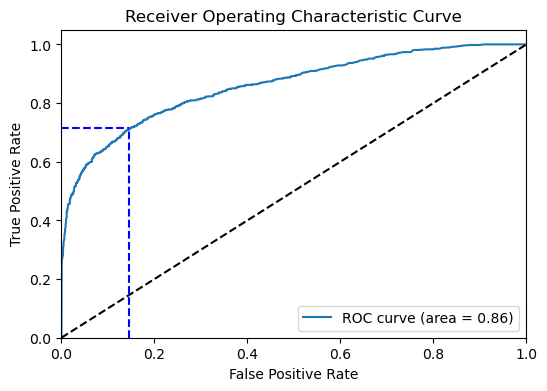

Feature Importances for RandomForestRegressor:
  Feature  Importance
0   sim_Y         1.0


Training GradientBoostingRegressor...
ROC AUC snap_label: 0.8645241841283463
Optimal threshold: 0.3379017208516483
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1770
           1       0.79      0.69      0.73       948

    accuracy                           0.82      2718
   macro avg       0.81      0.79      0.80      2718
weighted avg       0.82      0.82      0.82      2718



/tmp/ipykernel_1433252/547698018.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, fpr[optimal_idx]], [tpr[optimal_idx], tpr[optimal_idx]], 'k--', color='blue')
/tmp/ipykernel_1433252/547698018.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[optimal_idx], fpr[optimal_idx]], [0, tpr[optimal_idx]], 'k--', color='blue')


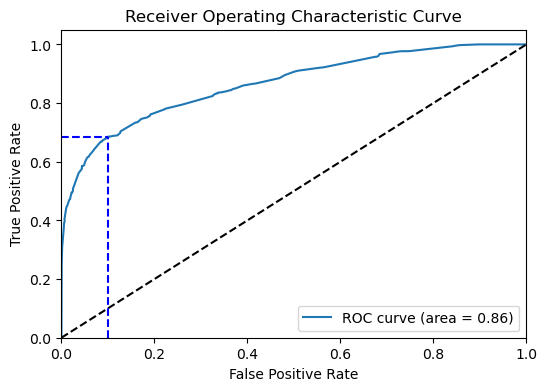

Feature Importances for GradientBoostingRegressor:
  Feature  Importance
0   sim_Y         1.0


Training GradientBoostingClassifier...
ROC AUC snap_label: 0.7708950153758134
Optimal threshold: 1.0
Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.81      0.95      0.88      1770
           1       0.87      0.59      0.70       948

    accuracy                           0.83      2718
   macro avg       0.84      0.77      0.79      2718
weighted avg       0.83      0.83      0.82      2718



/tmp/ipykernel_1433252/547698018.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, fpr[optimal_idx]], [tpr[optimal_idx], tpr[optimal_idx]], 'k--', color='blue')
/tmp/ipykernel_1433252/547698018.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[optimal_idx], fpr[optimal_idx]], [0, tpr[optimal_idx]], 'k--', color='blue')


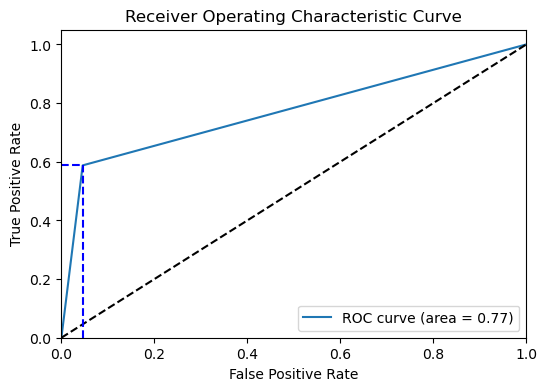

Feature Importances for GradientBoostingClassifier:
  Feature  Importance
0   sim_Y         1.0




In [10]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_curve

# Load the data
df_all = pd.read_csv('outputs/df_all_classify.csv')

# Preprocess the data
df_all.drop('id', axis=1, inplace=True)
df_all = pd.get_dummies(df_all, columns=['spec_charge'])

# Define the feature columns
# feature_cols = [col for col in df_all.columns if col not in ['label', 'spec_mass', 'sim_X', 'consistency']]
feature_cols = ['sim_Y']

# Define the label columns
label_cols = ['label']

# Separate the features and labels
X = df_all[feature_cols]
y = df_all[label_cols]

# Standardize the features
scaler = StandardScaler()
scaler.fit_transform(X)

# Apply SMOTE for 'label'
smote = SMOTE(random_state=42)
# X_res, y_res = smote.fit_resample(X, y['label'])
X_res, y_res = X, y['label']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Define the models and their associated hyperparameters
models = [
    {
        'name': 'RandomForestRegressor',
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [1, 10, 20, 30, 40],
            'min_samples_split': [2, 5, 10]
        }
    },
    {
        'name': 'GradientBoostingRegressor',
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'max_depth': [3, 5, 10, 20]
        }
    },
    {
        'name': 'GradientBoostingClassifier',
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'max_depth': [3, 5, 10, 20]
        }
    }
]

# Loop over the models
for m in models:
    print(f"Training {m['name']}...")

    # Apply GridSearchCV
    grid = GridSearchCV(m['model'], m['params'], cv=5, verbose=0, n_jobs=-1)
    grid.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_proba = grid.predict(X_val)

    # Scatter plot of y_pred_proba vs snap_score_1
    # scatter_plot(y_val['snap_1'], y_pred_proba, 'snap_score_1', 'y_pred_proba', f"Plot for {m['name']}", legend=True)

    # Calculate the ROC AUC for snap_label
    roc_auc_snap_label = roc_auc_score(y_val, y_pred_proba)

    # Print the ROC AUC
    print(f"ROC AUC snap_label: {roc_auc_snap_label}")

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

    # Find the optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # Print the optimal threshold
    print(f"Optimal threshold: {optimal_threshold}")

    # Convert probabilities to binary predictions using the optimal threshold
    y_pred_snap_label = (y_pred_proba >= optimal_threshold).astype(int)

    # Print the best hyperparameters
    print(f"Best hyperparameters: {grid.best_params_}")

    # Print the classification report for snap_label
    print(classification_report(y_val, y_pred_snap_label))

    # Plot the ROC curve
    plot_roc_curve(fpr, tpr, optimal_idx)

    # Get the feature importances
    feature_importances = grid.best_estimator_.feature_importances_

    # Create a DataFrame to display the feature importances
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': feature_importances
    })

    # Sort the DataFrame by importance in descending order
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Print the feature importances
    print(f"Feature Importances for {m['name']}:")
    print(importance_df)
    print("\n")


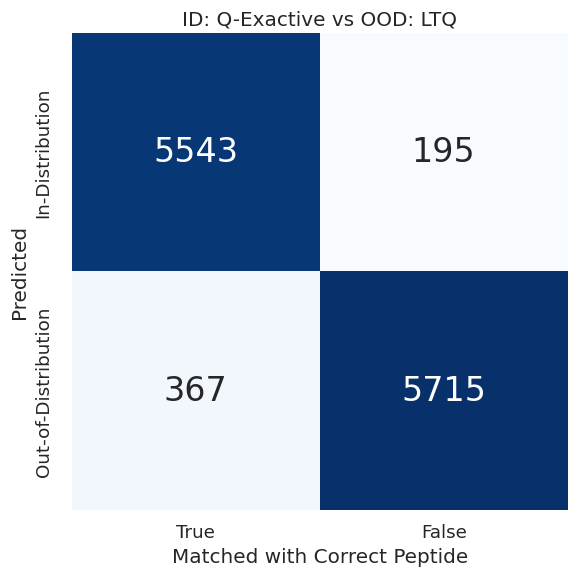

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Given values for the example
total_positive_examples = 6000
TPR = 94.5 / 100  # True Positive Rate in percentage
total_negative_examples = 5517
FPR = 8.1 / 100  # False Positive Rate in percentage

# # Calculating the values for the confusion matrix
# TP = int(TPR * total_positive_examples)  # True Positives
# FN = total_positive_examples - TP  # False Negatives
# FP = int(FPR * total_negative_examples)  # False Positives
# TN = total_negative_examples - FP  # True Negatives

TP = 5543
FP = 195
FN = 367
TN = 5715

# Creating the confusion matrix
confusion_matrix = [[TP, FP], [FN, TN]]

# Plotting the confusion matrix
plt.figure(figsize=(6, 6))
sns.set(font_scale=1.2)
ax = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues",
                 xticklabels=["True", "False"], cbar=False,
                 annot_kws={"size": 24})  # Increase font size here

# Center-aligning y-tick labels and adding margin
y_tick_labels = ["In-Distribution", "Out-of-Distribution"]
ax.set_yticklabels(y_tick_labels, va='center', ha='center')
plt.setp(ax.yaxis.get_majorticklabels(), 'x', -0.03)  # Adjust margin here; -0.3 is an example value

plt.title("ID: Q-Exactive vs OOD: LTQ")
plt.xlabel("Matched with Correct Peptide")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()